In [11]:
import pandas as pd
import numpy as np

In [5]:
message_file   = "MSFT_2012-06-21_34200000_57600000_message_10.csv"       # replace path
orderbook_file = "MSFT_2012-06-21_34200000_57600000_orderbook_10.csv"     # replace path

msg = pd.read_csv(message_file, header=None)
ob  = pd.read_csv(orderbook_file, header=None)

# message columns
msg.columns = ["time", "type", "orderID", "size", "price", "direction"]
ob.columns = [
    'Ask1', 'Ask_Vol1', 'Bid1', 'Bid_Vol1',
    'Ask2', 'Ask_Vol2', 'Bid2', 'Bid_Vol2',
    'Ask3', 'Ask_Vol3', 'Bid3', 'Bid_Vol3',
    'Ask4', 'Ask_Vol4', 'Bid4', 'Bid_Vol4',
    'Ask5', 'Ask_Vol5', 'Bid5', 'Bid_Vol5',
    'Ask6', 'Ask_Vol6', 'Bid6', 'Bid_Vol6',
    'Ask7', 'Ask_Vol7', 'Bid7', 'Bid_Vol7',
    'Ask8', 'Ask_Vol8', 'Bid8', 'Bid_Vol8',
    'Ask9', 'Ask_Vol9', 'Bid9', 'Bid_Vol9',
    'Ask10', 'Ask_Vol10', 'Bid10', 'Bid_Vol10'
]

(4012590, 26750600)

In [7]:
msg.head()

,time,type,orderID,size,price,direction
0,34200.013994,3,16085616,100,310400,-1
1,34200.013994,1,16116348,100,310500,-1
2,34200.015248,1,16116658,100,310400,-1
3,34200.015442,1,16116704,100,310500,-1
4,34200.015789,1,16116752,100,310600,-1


In [9]:
ob.head()

,Ask1,Ask_Vol1,Bid1,Bid_Vol1,Ask2,Ask_Vol2,Bid2,Bid_Vol2,Ask3,Ask_Vol3,...,Bid8,Bid_Vol8,Ask9,Ask_Vol9,Bid9,Bid_Vol9,Ask10,Ask_Vol10,Bid10,Bid_Vol10
0,309900,3788,309500,300,310500,100,309300,3986,310600,100,...,308600,400,311300,100,308500,400,311400,100,308400,1600
1,309900,3788,309500,300,310500,200,309300,3986,310600,100,...,308600,400,311300,100,308500,400,311400,100,308400,1600
2,309900,3788,309500,300,310400,100,309300,3986,310500,200,...,308600,400,311100,4500,308500,400,311300,100,308400,1600
3,309900,3788,309500,300,310400,100,309300,3986,310500,300,...,308600,400,311100,4500,308500,400,311300,100,308400,1600
4,309900,3788,309500,300,310400,100,309300,3986,310500,300,...,308600,400,311100,4500,308500,400,311300,100,308400,1600


In [13]:
msg.shape, ob.shape

((668765, 6), (668765, 40))

In [19]:
# extract useful dimensions
N_levels = 10

In [17]:
# ===============================
# 2. Define trading window
# ===============================

# LOBSTER time is in SECONDS after midnight
start_time = msg["time"].min()
end_time   = msg["time"].max()
T = end_time - start_time     # length of window in seconds
T

23399.893802407998

In [29]:
# ===============================
# 3. Compute best bid/ask at each row
# ===============================

ask_prices = ob.iloc[:, 0:4*N_levels+1:4]
ask_volumes = ob.iloc[:, 1:4*N_levels+1:4]
bid_prices = ob.iloc[:, 2:4*N_levels+1:4]
bid_volumes = ob.iloc[:, 3:4*N_levels+1:4]
ask_prices, bid_prices, ask_volumes, bid_volumes

(          Ask1    Ask2    Ask3    Ask4    Ask5    Ask6    Ask7    Ask8  \
 0       309900  310500  310600  310700  310800  310900  311000  311100   
 1       309900  310500  310600  310700  310800  310900  311000  311100   
 2       309900  310400  310500  310600  310700  310800  310900  311000   
 3       309900  310400  310500  310600  310700  310800  310900  311000   
 4       309900  310400  310500  310600  310700  310800  310900  311000   
 ...        ...     ...     ...     ...     ...     ...     ...     ...   
 668760  301400  301500  301600  301700  301800  301900  302000  302100   
 668761  301400  301500  301600  301700  301800  301900  302000  302100   
 668762  301400  301500  301600  301700  301800  301900  302000  302100   
 668763  301400  301500  301600  301700  301800  301900  302000  302100   
 668764  301400  301500  301600  301700  301800  301900  302000  302100   
 
           Ask9   Ask10  
 0       311300  311400  
 1       311300  311400  
 2       311100  311

In [31]:
best_ask = ask_prices.iloc[:, 0]
best_bid = bid_prices.iloc[:, 0]
best_ask, best_bid

(0         309900
 1         309900
 2         309900
 3         309900
 4         309900
            ...  
 668760    301400
 668761    301400
 668762    301400
 668763    301400
 668764    301400
 Name: Ask1, Length: 668765, dtype: int64,
 0         309500
 1         309500
 2         309500
 3         309500
 4         309500
            ...  
 668760    301300
 668761    301300
 668762    301300
 668763    301300
 668764    301300
 Name: Bid1, Length: 668765, dtype: int64)

In [33]:
# ===============================
# 4. MARKET ORDER INTENSITY λM
# Types 4 & 5 = marketable executions
# ===============================

market_mask = msg["type"].isin([4, 5])
N_M = market_mask.sum()

lambda_M = N_M / (2 * T)

print("Total Orders=", N_M, "λ_M =", lambda_M)

Total Orders= 33414 λ_M = 0.71397759926076


In [41]:
# ===============================
# 5. Compute tick distance for each event
# ===============================

tick_size = 100  # LOBSTER uses price * 1 = 1 tick = 0.0001 dollars

def compute_distance(row):
    """Compute tick distance from best opposite quote."""
    price = row["price"]
    direction = row["direction"]
    idx = row.name
    
    if direction == 1:  # BUY limit order → compare against BEST ASK
        return int((best_ask.iloc[idx] - price) / tick_size)
    elif direction == -1:  # SELL limit order → compare against BEST BID
        return int((price - best_bid.iloc[idx]) / tick_size)
    else:
        return np.nan

msg["distance"] = msg.apply(compute_distance, axis=1)

# Drop negative or nonsensical distances
msg = msg[msg["distance"].notna()]
msg = msg[msg["distance"] >= 0]
msg

,time,type,orderID,size,price,direction,distance
0,34200.013994,3,16085616,100,310400,-1,9
1,34200.013994,1,16116348,100,310500,-1,10
2,34200.015248,1,16116658,100,310400,-1,9
3,34200.015442,1,16116704,100,310500,-1,10
4,34200.015789,1,16116752,100,310600,-1,11
...,...,...,...,...,...,...,...
668760,57599.861466,3,287081309,9249,301400,-1,1
668761,57599.861567,3,287117122,783,301400,-1,1
668762,57599.873177,3,287070525,800,301500,-1,2
668763,57599.907797,5,0,100,301350,-1,0


In [43]:
msg['distance'].max(), msg['distance'].min()

(21, 0)

In [49]:
# ===============================
# 6. LIMIT ORDER INTENSITY λLi
# Type 1 = new limit order
# ===============================

lambda_L = []

limit_mask = msg["type"] == 1
limit_events = msg[limit_mask]

K = 30 # Max distance on either ask or buy side = 30, say

for i in range(K):  # compute for distances from 0 to 49 ticks
    N_L_i = (limit_events["distance"] == i).sum()
    lambda_L.append(N_L_i / (2 * T))

print("λ_Li:")
for i in range(K):
    print(i, lambda_L[i])

λ_Li:
0 0.0
1 2.8007178388671097
2 2.244475998202834
3 0.605750612361384
4 0.3152151057728716
5 0.28615514482851795
6 0.20290690377028123
7 0.13066298615788435
8 0.12581253679437826
9 0.1872017042893254
10 0.12158174836277383
11 0.02126078024972934
12 0.0001709409467314922
13 6.410285502430958e-05
14 0.0
15 6.410285502430958e-05
16 0.0
17 0.0
18 0.0
19 0.0
20 0.0
21 0.0
22 0.0
23 0.0
24 0.0
25 0.0
26 0.0
27 0.0
28 0.0
29 0.0


In [79]:
# ===============================
# 7. AVERAGE STANDING VOLUME ⟨X_i⟩ AT i TICKS FROM BEST OPPOSITE QUOTE
# ===============================

# Use your already-sliced DataFrames:
# ask_prices, ask_volumes, bid_prices, bid_volumes, best_ask, best_bid
# tick_size and K are already defined

# Convert to numpy for speed
ask_p = ask_prices.to_numpy()
ask_v = ask_volumes.to_numpy()
bid_p = bid_prices.to_numpy()
bid_v = bid_volumes.to_numpy()

best_bid_np = best_bid.to_numpy()
best_ask_np = best_ask.to_numpy()

# Distances (in ticks)
# Ask distances from best BID (opposite of buy side)
dist_ask_from_best_bid = (ask_p - best_bid_np[:, None]) // tick_size
# Bid distances from best ASK (opposite of sell side)
dist_bid_from_best_ask = (best_ask_np[:, None] - bid_p) // tick_size

# Mask out unoccupied/dummy levels (volume==0 is safest)
INVALID = -10**9
dist_ask_from_best_bid[ask_v == 0] = INVALID
dist_bid_from_best_ask[bid_v == 0] = INVALID

# Time-average total standing volume at exactly i ticks from the best opposite quote
avg_X_from_best_bid = np.zeros(K, dtype=float)   # ask side vs best bid
avg_X_from_best_ask = np.zeros(K, dtype=float)   # bid side vs best ask

for i in range(K):
    # sum volumes across all levels that are exactly i ticks away, row by row, then average over time
    mask_i_ask = (dist_ask_from_best_bid == i)
    vol_i_ask_per_row = (ask_v * mask_i_ask).sum(axis=1)
    avg_X_from_best_bid[i] = vol_i_ask_per_row.mean()

    mask_i_bid = (dist_bid_from_best_ask == i)
    vol_i_bid_per_row = (bid_v * mask_i_bid).sum(axis=1)
    avg_X_from_best_ask[i] = vol_i_bid_per_row.mean()

# Symmetric ⟨X_i⟩: average of both sides at distance i from best opposite quotes
avg_X_opposite = 0.5 * (avg_X_from_best_bid + avg_X_from_best_ask)

print("⟨X_i⟩ from best bid (ask-side):", avg_X_from_best_bid)
print("⟨X_i⟩ from best ask (bid-side):", avg_X_from_best_ask)
print("⟨X_i⟩ symmetric (used for λ_C):", avg_X_opposite)

⟨X_i⟩ from best bid (ask-side): [0.00000000e+00 1.03122283e+04 1.86496228e+04 1.79320432e+04
 1.77328538e+04 1.67648668e+04 1.53023928e+04 1.41052795e+04
 1.32143295e+04 1.16313245e+04 9.66081276e+03 1.97343984e+03
 3.01672187e+00 6.77427796e-02 4.75551203e-01 3.76813978e-02
 8.07458524e-02 0.00000000e+00 8.97176138e-04 4.48588069e-04
 1.49529356e-04 1.49529356e-04 0.00000000e+00 8.97176138e-04
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
⟨X_i⟩ from best ask (bid-side): [0.00000000e+00 9.91181207e+03 1.84168381e+04 1.84717002e+04
 1.90448588e+04 1.80589012e+04 1.54782923e+04 1.36966469e+04
 1.21497059e+04 1.04995769e+04 9.11267689e+03 1.67041060e+03
 1.70677443e+00 9.85278835e-02 1.70463466e-02 5.59239793e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
⟨X_i⟩ symmetric (u

In [63]:
# ===============================
# 8. CANCELLATION INTENSITY λ_Ci
# Types 2 & 3 = cancellations
# Normalize by ⟨X_i⟩ and 2T
# ===============================
cancel_events = msg[msg["type"].isin([2, 3])]

lambda_C = np.full(K, np.nan, dtype=float)
for i in range(K):
    N_C_i = (cancel_events["distance"] == i).sum()
    Xi = avg_X_opposite[i]
    lambda_C[i] = (N_C_i / (Xi * 2 * T)) if Xi > 0 else np.nan

print("λ_Ci:")
for i in range(K):
    print(i, lambda_C[i])

λ_Ci:
0 nan
1 0.00023303166981948292
2 0.0001243129589140864
3 2.9647456575127934e-05
4 1.7837667750180147e-05
5 1.231112880930371e-05
6 1.180399268629295e-05
7 9.258147335300392e-06
8 1.225915266555177e-05
9 1.5996578427212917e-05
10 1.5071785133331117e-05
11 3.8585263348863975e-06
12 4.523686905862371e-05
13 0.0
14 0.0
15 0.0
16 0.0
17 nan
18 0.04763305093370266
19 0.09526610186740532
20 0.285798305602216
21 0.285798305602216
22 nan
23 0.0
24 nan
25 nan
26 nan
27 nan
28 nan
29 nan


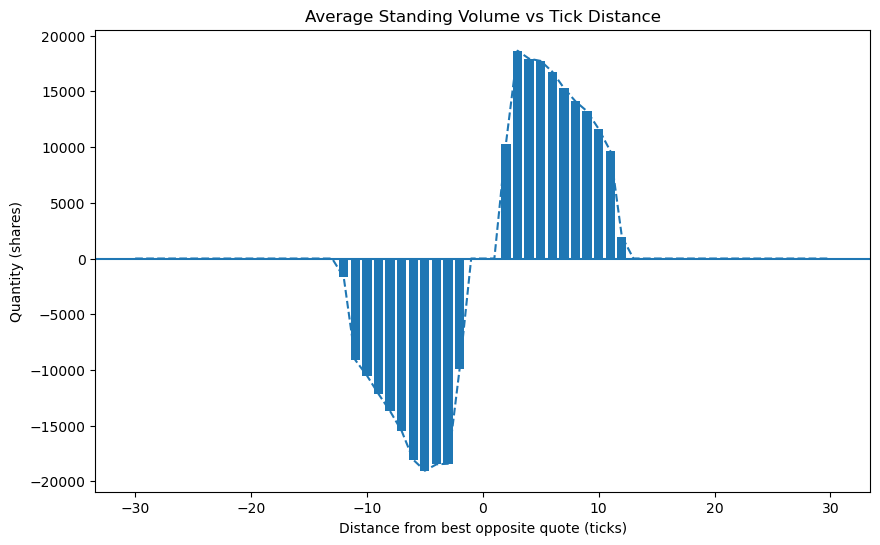

In [83]:
import numpy as np
import matplotlib.pyplot as plt

# Make sure the following exist:
# avg_X_from_best_bid  (length K)
# avg_X_from_best_ask  (length K)
# K = number of distance bins (e.g., 30)

# X-axis ticks:
distances = np.arange(-K, K+1)

# Construct Y data:
# Negative distances = BID volumes (negative sign so they plot downward)
Y_bid = -avg_X_from_best_ask[::-1]

# Positive distances = ASK volumes
Y_ask = avg_X_from_best_bid

# Combine for full symmetric plot
Y = np.concatenate([Y_bid, [0], Y_ask])

# ==========================
# Plot
# ==========================

plt.figure(figsize=(10,6))

# Bar plot
plt.bar(distances, Y, width=0.8)

# Dashed line overlay (same data)
plt.plot(distances, Y, linestyle='--')

plt.axhline(0)  # zero line
plt.xlabel("Distance from best opposite quote (ticks)")
plt.ylabel("Quantity (shares)")
plt.title("Average Standing Volume vs Tick Distance")

plt.show()


In [67]:
avg_X_from_best_ask

array([0.00000000e+00, 9.91181207e+03, 1.84168381e+04, 1.84717002e+04,
       1.90448588e+04, 1.80589012e+04, 1.54782923e+04, 1.36966469e+04,
       1.21497059e+04, 1.04995769e+04, 9.11267689e+03, 1.67041060e+03,
       1.70677443e+00, 9.85278835e-02, 1.70463466e-02, 5.59239793e-02,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

In [69]:
avg_X_from_best_bid

array([0.00000000e+00, 1.03122283e+04, 1.86496228e+04, 1.79320432e+04,
       1.77328538e+04, 1.67648668e+04, 1.53023928e+04, 1.41052795e+04,
       1.32143295e+04, 1.16313245e+04, 9.66081276e+03, 1.97343984e+03,
       3.01672187e+00, 6.77427796e-02, 4.75551203e-01, 3.76813978e-02,
       8.07458524e-02, 0.00000000e+00, 8.97176138e-04, 4.48588069e-04,
       1.49529356e-04, 1.49529356e-04, 0.00000000e+00, 8.97176138e-04,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00])

In [71]:
X_init_ask = np.round(avg_X_from_best_bid).astype(int)

In [73]:
X_init_ask

array([    0, 10312, 18650, 17932, 17733, 16765, 15302, 14105, 13214,
       11631,  9661,  1973,     3,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0])

In [87]:
X_init_bid = np.round(avg_X_from_best_ask).astype(int)

In [89]:
X_init_bid

array([    0,  9912, 18417, 18472, 19045, 18059, 15478, 13697, 12150,
       10500,  9113,  1670,     2,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0])